In [2]:

'''
---------------------------------------------------------------
Simulation for Function-on-Function Linear Regression
---------------------------------------------------------------
* 1 d

* 1 Response Y & 1 Predictor X   

* Sparse (num of grid: 21)

* Training samp size: 200
  Test     samp size: 100

* Using Gaussian Kernal Function in LPR

* Using Leave-One-Curve-Out CV for bandwidth selection in LPR 
---------------------------------------------------------------
'''
#####

import GetData
import FFReg
import Plotting
import lpr
import time
import scipy as sp
from scipy import io

###
import numpy as np
# ---------
# Settings
# ---------
# sim_rep_time = 100

tran_samp_size = 200
test_samp_size = 100
samp_size = tran_samp_size + test_samp_size

range_num_pts = np.array([2, 6])
num_pts = range_num_pts[1]

# -------------
# Setting of X
# -------------
def X_Mean_Func(s):
    #input, output: vector
    return(s /  + 2 * np.sin(s))

def Eigen_Funcs_X(s):
    #input  :d-vector
    #output:array with dim (2 * d)
    return(np.array([np.sqrt(2 / 5) * -np.cos(2 * np.pi * s / 5), 
                     np.sqrt(2 / 5) *  np.sin(2 * np.pi * s / 5),
                     np.sqrt(2 / 5) * -np.cos(4 * np.pi * s / 5)]))

num_grid_X = 21
range_X = np.array([0, 5])
X_eigen_val = np.array([9, 4, 1])

# -------------
# Setting of Y
# -------------

def Y_Mean_Func(s):
    #input, output: vector
    return(s / 2 + np.sin(s))

def Eigen_Funcs_Y(s):
    #input  :d-vector
    #output:array with dim (2 * d)
    return(np.array([np.sqrt(2 / 5) * -np.cos(np.pi * s / 5), 
                     np.sqrt(2 / 5) * np.sin(np.pi * s / 5),
                     np.sqrt(2 / 5) * -np.cos(2 * np.pi * s / 5)])) 

num_grid_Y = 21

range_Y = np.array([0, 5])

B = np.array([[1, 0.8, 0.8], [-1, 0.5, -0.5],[0.8, -0.5, 0.2]])

# bandwidth
X_candidate_h_mean = np.arange(0.15, 1, 0.05).reshape(-1, 1)
X_candidate_h_cov = np.arange(0.1, 0.5, 0.05).repeat(2).reshape(-1, 2)
X_candidate_h_diag_cov = np.arange(0.1, 0.8, 0.05).reshape(-1, 1)

Y_candidate_h_mean = np.arange(0.15, 1, 0.05).reshape(-1, 1)
Y_candidate_h_cov = np.arange(0.1, 0.5, 0.05).repeat(2).reshape(-1, 2)

X_Y_candidate_h_cov = np.asanyarray(np.meshgrid(np.linspace(0.2, 0.8, 7), 
                                                 np.linspace(0.2, 0.8, 7))).T.reshape(-1,2)

In [3]:
name = ['X', 'Y']

In [4]:
sim_rep_time = 100

In [5]:
#Generate and save data

np.random.seed(104)
X_data = []
Y_data = []
for i in range(sim_rep_time):
    X_data.append(GetData.Get_X_data(Mean_Func  = X_Mean_Func,
                                     Eigen_Funcs = Eigen_Funcs_X, 
                                     eigen_val  = X_eigen_val, 
                                     domain = range_X, 
                                     tran_size  = tran_samp_size, 
                                     test_size  = test_samp_size,
                                     num_grid = num_grid_X,
                                     sparse  = True,
                                     num_pts = range_num_pts))


    #Generate Simulation data of Y

    Y_data.append(GetData.Get_Y_data(Mean_Func = Y_Mean_Func, 
                                     Eigen_Funcs = Eigen_Funcs_Y,
                                     X_fpcs = [X_data[i].fpcs],
                                     B = [B], 
                                     domain = range_Y, 
                                     test_size = test_samp_size, 
                                     num_grid = num_grid_Y,
                                     sparse  = True,
                                     num_pts = range_num_pts))
    
    #Save data
    # for 'refund' in R
    datas = [X_data[i], Y_data[i]]
    for j in range(2):
        np.savetxt('tran '+ name[j] + ' of samp ' + np.str(i + 1), np.column_stack((datas[j].obs_tran)), 
                   newline='\n' ,delimiter = ' ', fmt="%s")
        
        np.savetxt('test '+ name[j] + ' of samp ' + np.str(i + 1), np.column_stack((datas[j].obs_test)), 
                   newline='\n', delimiter = ' ', fmt="%s")
        
        np.savetxt('real_on_grid '+ name[j] + ' of samp ' + np.str(i + 1), np.column_stack((datas[j].real_val_on_grid)), 
                   newline='\n', delimiter = ' ', fmt="%s")
        
        np.savetxt('tran_time_pt '+ name[j] + ' of samp ' + np.str(i + 1), np.column_stack((datas[j].tran_time_pts)), 
                   newline='\n', delimiter = ' ', fmt="%s")
        
        np.savetxt('test_time_pt '+ name[j] + ' of samp ' + np.str(i + 1), np.column_stack((datas[j].test_time_pts)), 
                   newline='\n', delimiter = ' ', fmt="%s")

    #for 'PACE' in Matlab
    X_sim_data = {'t': np.bmat([[X_data[i].tran_time_pts],[X_data[i].test_time_pts]]), 
                  'obs': np.bmat([[X_data[i].obs_tran],[X_data[i].obs_test]]), 
                  'fpcs': X_data[i].fpcs}
    Y_sim_data = {'t': np.bmat([[Y_data[i].tran_time_pts],[Y_data[i].test_time_pts]]), 
                  'obs': np.bmat([[Y_data[i].obs_tran],[Y_data[i].obs_test]]), 
                  'fpcs': Y_data[i].fpcs,
                  'real_test_Y': Y_data[i].real_val_on_grid[tran_samp_size:,]}
    
    sp.io.savemat('d:/Work_Jupyter/敏/SIM_1y1x_sparse/sim_X_data_'+str(i+1)+'.mat', X_sim_data)
    sp.io.savemat('d:/Work_Jupyter/敏/SIM_1y1x_sparse/sim_Y_data_'+str(i+1)+'.mat', Y_sim_data)
    
sp.io.savemat('d:/Work_Jupyter/敏/SIM_1y1x_sparse/sim_X_time_grid.mat',
                {'grid': X_data[0].time_grid})
sp.io.savemat('d:/Work_Jupyter/敏/SIM_1y1x_sparse/sim_Y_time_grid.mat',
                {'grid': Y_data[0].time_grid})



D:\Program\Miniconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:161: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
D:\Program\Miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:2469: RuntimeWarning: invalid value encountered in less
  out_of_bounds += x < grid[0]
D:\Program\Miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:2470: RuntimeWarning: invalid value encountered in greater
  out_of_bounds += x > grid[-1]


Bandwidth of cov:  [ 0.4  0.3]


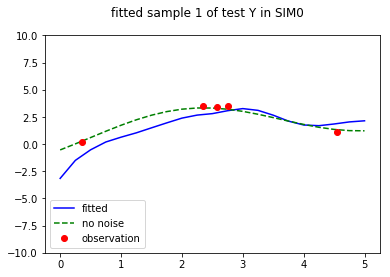

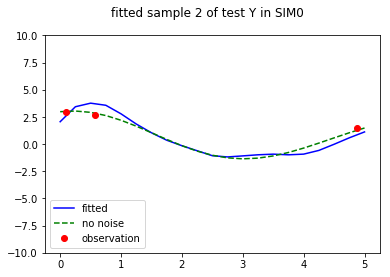

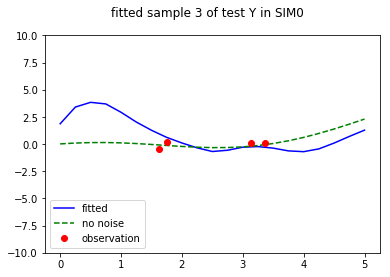

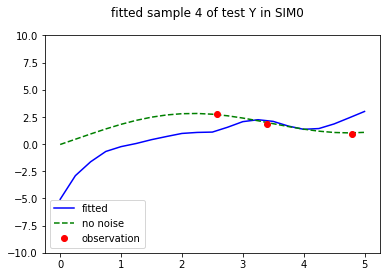

Bandwidth of cov:  [ 0.3  0.4]


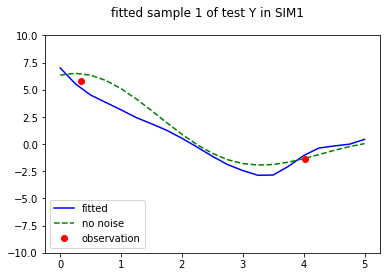

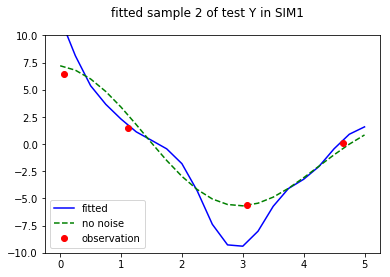

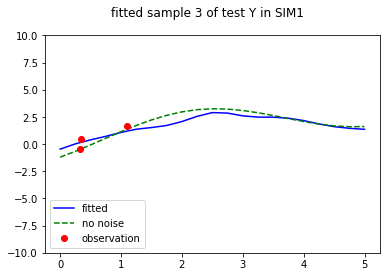

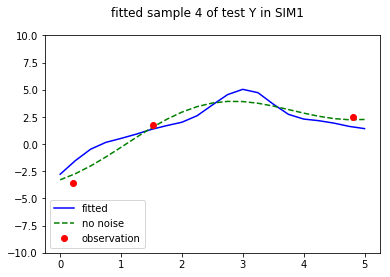

Bandwidth of cov:  [ 0.4  0.4]


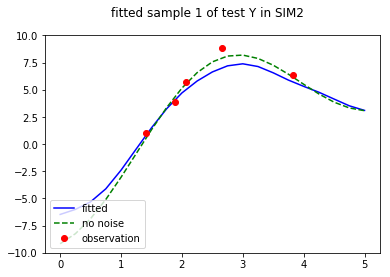

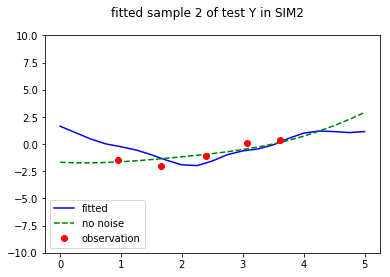

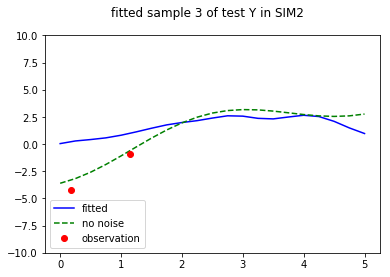

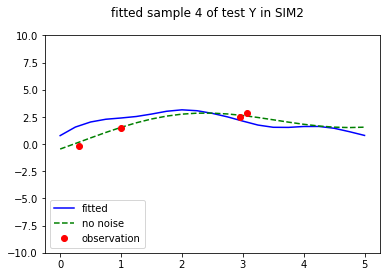

Bandwidth of cov:  [ 0.4  0.4]


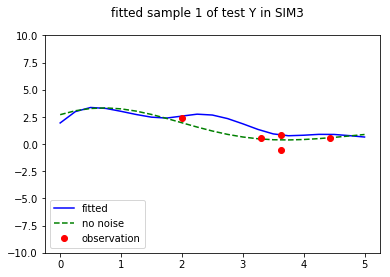

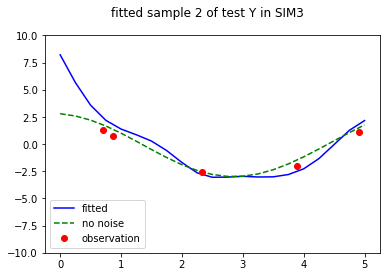

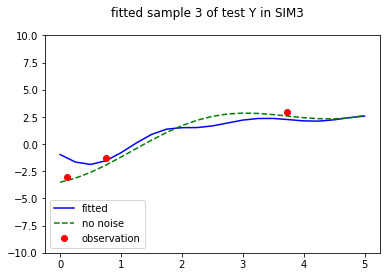

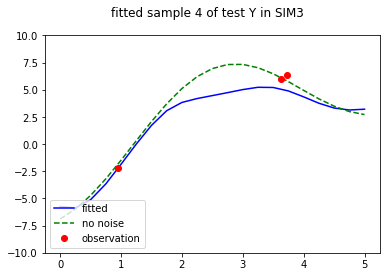

Bandwidth of cov:  [ 0.3  0.4]


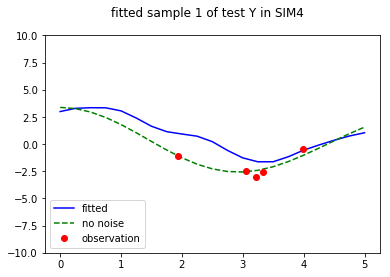

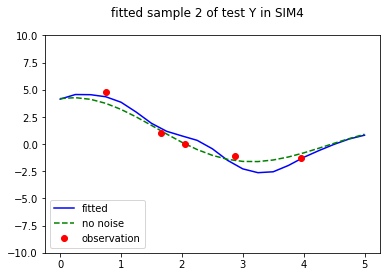

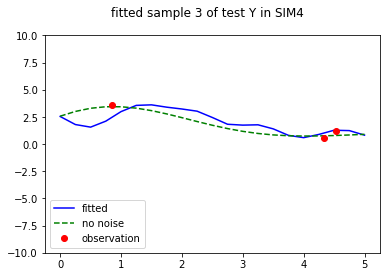

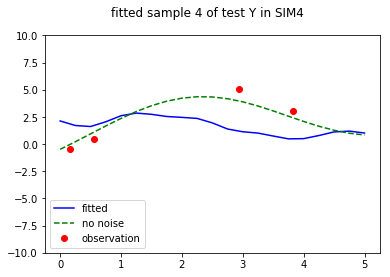

Bandwidth of cov:  [ 0.6  0.3]


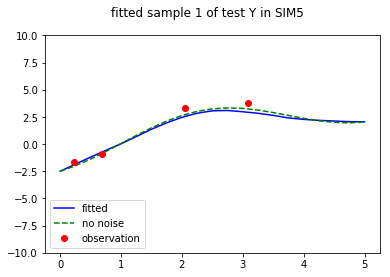

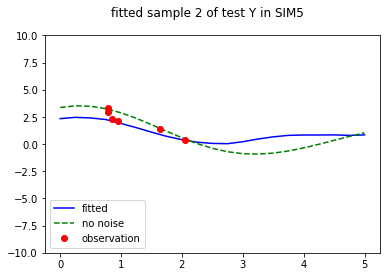

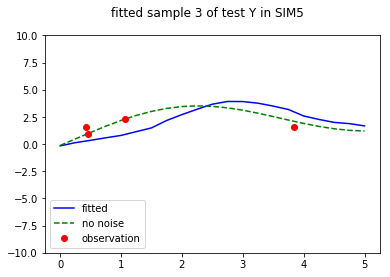

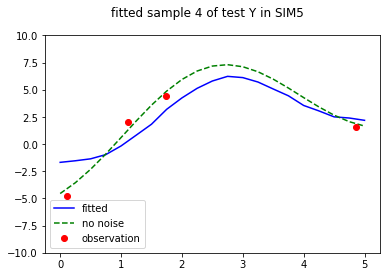

Bandwidth of cov:  [ 0.4  0.3]


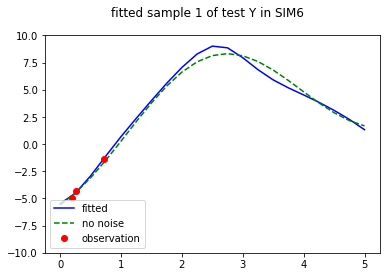

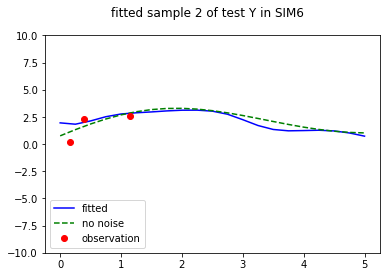

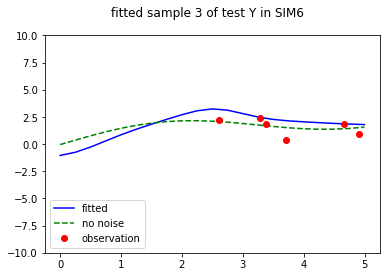

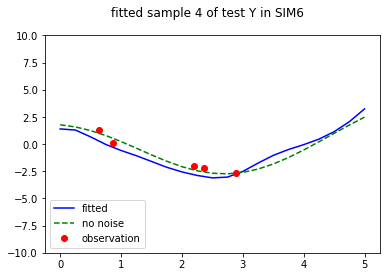

Bandwidth of cov:  [ 0.6  0.5]


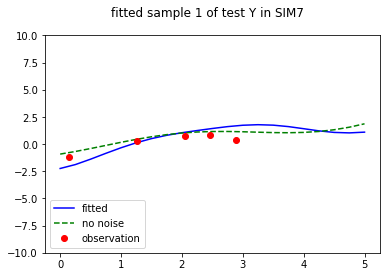

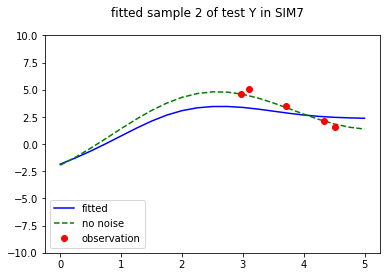

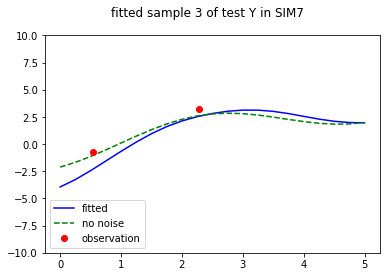

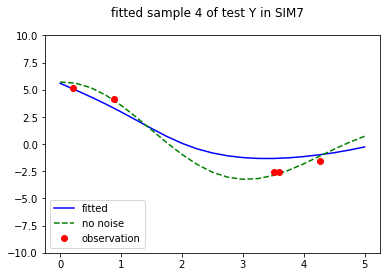

Bandwidth of cov:  [ 0.4  0.3]


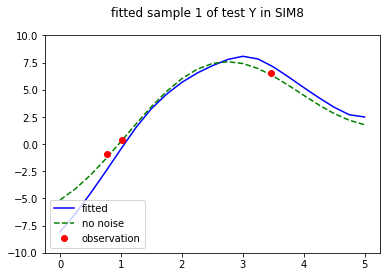

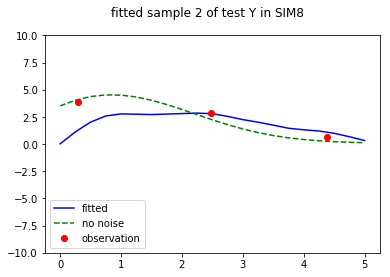

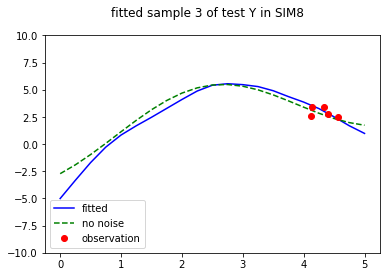

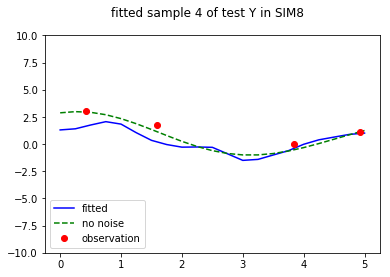

Bandwidth of cov:  [ 0.6  0.5]


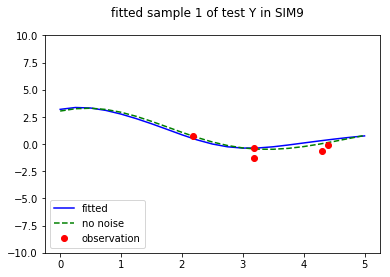

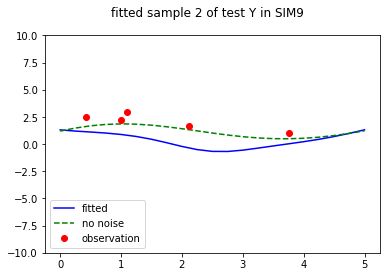

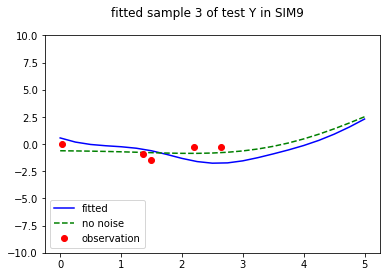

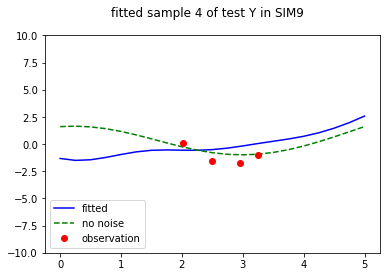

224.4168360233307


In [13]:
my_MISE   = np.zeros(sim_rep_time)
my_RMSPE  = np.zeros(sim_rep_time)
my_MaxAbs = np.zeros(sim_rep_time)
start_time = time.time()
for i in range(10):
    '''
    Results of X
    '''

    result_X = FFReg.Get_FPCA_Result(X_data[i], X_candidate_h_mean, 
                                      X_candidate_h_cov, X_candidate_h_diag_cov, 
                                      ker_fun = 'Gaussian')
    #fitting test sample
    fit_test_X = result_X.Restruect_Fun(X_data[i].test_time_pts.reshape(test_samp_size, num_pts, 1),
                                         X_data[i].obs_test)[1]

    '''
    Results of Y
    '''


    result_Y = FFReg.Fit_Mean_and_Cov(Y_data[i], Y_candidate_h_mean, 
                                      Y_candidate_h_cov, ker_fun = 'Gaussian')


    '''
    Construct Coefficient Function

        1. fit cov_Xi_Xj
        2. fit cov_Xi_Y
        3. combine them to build coefficient function

    '''
    fit_cov_XY = FFReg.Fit_Cov_XY(X_time_pts = X_data[i].tran_time_pts,
                                    Y_time_pts = Y_data[i].tran_time_pts,
                                    obs_X = X_data[i].obs_tran, 
                                    obs_Y = Y_data[i].obs_tran,
                                    X_time_grid = X_data[i].time_grid,
                                    Y_time_grid = Y_data[i].time_grid, 
                                    fit_X_mean = result_X.mean_fun, 
                                    fit_Y_mean = result_Y.mean_fun, 
                                    candidate_h_cov = X_Y_candidate_h_cov, 
                                    ker_fun = 'Gaussian')

    '''
    Coefficient Function
    '''

    fit_cov_XX = result_X.cov_fun

    inv_fit_cov_XX = np.linalg.pinv(fit_cov_XX, rcond= 0.07)

    fit_Beta_without_delta =  np.matmul(inv_fit_cov_XX,fit_cov_XY)

    ## add delta
    if i == 0:
        delta = np.diag(np.repeat([X_data[i].time_grid[1] - X_data[i].time_grid[0]],
                                   [num_grid_X]))
        delta_inv = np.linalg.inv(delta)

    fit_Beta  = np.matmul(delta_inv, fit_Beta_without_delta)


    #---------------------------------------
    # fit Response of test set on grid
    #---------------------------------------
    fit_test_X_center = fit_test_X - result_X.mean_fun


    #compute test_Y(on grid pts)
    fit_test_Y = result_Y.mean_fun + np.matmul(fit_Beta_without_delta.T, fit_test_X_center.T).T


    #real value of test_Y (on grid pts)
    real_test_Y = Y_data[i].real_val_on_grid[tran_samp_size:,:]
    Plotting.Plot_Restruct_Funcs(fit_X = np.asarray(fit_test_Y),
                                 real_X= Y_data[i].real_val_on_grid[tran_samp_size:],
                                 time_grid = Y_data[i].time_grid,
                                 obs_X= Y_data[i].obs_test,
                                 obs_time=Y_data[i].test_time_pts,
                                 name='test Y in SIM'+str(i),
                                 num_plot= 4,
                                 y_lim= [-10,10]
                                 ,legend_location = 3)

    #========================================================
    #compute RMSPE (relative mean squared prediction error)
    #========================================================

    my_RMSPE[i] = (np.square(real_test_Y - fit_test_Y)).sum() /(real_test_Y**2).sum() / test_samp_size

    #======================================
    #compute Mean integrated squared error
    #======================================

    my_MISE[i] = np.sum(np.square(real_test_Y - fit_test_Y) * (Y_data[i].time_grid[1] - Y_data[i].time_grid[0]), 1).mean()

    # maxima of absolute error
    my_MaxAbs[i] = np.abs(real_test_Y - fit_test_Y).max()
    
print(time.time()-start_time)


np.savetxt('MISE_sparse', my_MISE, newline='\n', delimiter = ' ', fmt="%s")
np.savetxt('RMSPE_sparse', my_RMSPE, newline='\n', delimiter = ' ', fmt="%s")

In [14]:
PACE_result = sp.io.loadmat('d:/Work_Jupyter/敏/SIM_1y1x_sparse/result_PACE_sparse.mat')

In [74]:
# create the quantile value of each array
# save in tuple
quantile_order = [0, 25, 50, 75, 100]

quantile_PACE_MISE = []
quantile_PACE_RMSPE = []
quantile_my_MISE = []
quantile_my_RMSPE = []

for quan in quantile_order:
    quantile_PACE_MISE.append(np.asscalar(np.percentile(PACE_result['MISE'], [quan])))
    quantile_PACE_RMSPE.append(np.asscalar(np.percentile(PACE_result['RMSPE'], [quan])))
    
    quantile_my_MISE.append(np.asscalar(np.percentile(my_MISE, [quan])))
    quantile_my_RMSPE.append(np.asscalar(np.percentile(my_RMSPE, [quan])))
        
quantile_PACE_MISE = tuple(quantile_PACE_MISE)
quantile_PACE_RMSPE = tuple(quantile_PACE_RMSPE)
quantile_my_MISE = tuple(quantile_my_MISE)
quantile_my_RMSPE = tuple(quantile_my_RMSPE)

In [102]:
# print table
# compare MISE of 'PACE'(from matlab) and FFReg
print("=========================================================================")
print("             Compare Mean Integrated Squared Error             ")
print("=========================================================================")
print("|      method    |   min   | 1st quan. |  median  | 3rd quan. |   max   |")
print("-------------------------------------------------------------------------")
print(" PACE in matlab" ,5 * " %10.5f"%quantile_PACE_MISE[:5])
print("-------------------------------------------------------------------------")
print("   my  method  " ,5 * " %10.5f"%quantile_my_MISE[:5])
print("=========================================================================")
print("  ")
# compare RMSPE of 'PACE'(from matlab) and FFReg
print("=========================================================================")
print("         Compare Relative Mean Squared Prediction Error        ")
print("=========================================================================")
print("|      method    |   min   | 1st quan. |  median  | 3rd quan. |   max   |")
print("-------------------------------------------------------------------------")
print(" PACE in matlab" ,5 * " %10.5f"%quantile_PACE_RMSPE[:5])
print("-------------------------------------------------------------------------")
print("   my  method  " ,5 * " %10.5f"%quantile_my_RMSPE[:5])
print("=========================================================================")


             Compare Mean Integrated Squared Error             
|      method    |   min   | 1st quan. |  median  | 3rd quan. |   max   |
-------------------------------------------------------------------------
 PACE in matlab     6.66999   12.09870   16.97367   33.42868  196.61487
-------------------------------------------------------------------------
   my  method       5.37895    7.49071    8.34290    9.25416   15.00029
  
         Compare Relative Mean Squared Prediction Error        
|      method    |   min   | 1st quan. |  median  | 3rd quan. |   max   |
-------------------------------------------------------------------------
 PACE in matlab     0.29467    0.52304    0.81402    1.38515    6.11671
-------------------------------------------------------------------------
   my  method       0.00109    0.00172    0.00193    0.00222    0.00332
